# Mini Lab One

### MSDS7331: Data Mining
### Section 0403
### Summer 2018

- Anthony Schams
- Laura Ludwig  
- David Stroud
- Joshua Balson

## Create Models

### Import the data

Here we are adding in the natural language processing features from the python NLTK packages

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
#from keras.preprocessing import sequence, text
#from keras.layers import Input, Embedding
from nltk import word_tokenize
from nltk.corpus import stopwords
# from textblob import TextBlob
import datetime as dt
import warnings
import string

df_train = pd.read_csv('train.csv')
df_resources = pd.read_csv('resources.csv')
train_resource = pd.merge(df_train, df_resources, on="id", how='left')
df_train[df_train.teacher_prefix.isnull()]
train_resource[train_resource.description.isnull()].head()
t2 = train_resource.pivot_table(index = ['id', 'description'],
                                values='quantity', 
                                aggfunc=np.sum)
t2.reset_index(inplace=True)
train_resource = pd.merge(train_resource,
                          t2, 
                          on=['id', 'description'], 
                          how='right',
                          suffixes=('_Orig', '_True'))

train_resource = train_resource.drop_duplicates()
train_resource = train_resource.drop('quantity_Orig', axis=1)
train_resource = train_resource.rename(columns={'quantity_True': 'True_Quantity'})
train_resource['Total_Cost'] = train_resource.price * train_resource.True_Quantity
Total_cost = train_resource.pivot_table(values=['Total_Cost','True_Quantity'],
                                        index='id',
                                        aggfunc={'Total_Cost' : np.sum, 'True_Quantity' : np.sum})
Total_cost.reset_index(level=0, inplace = True)

df_train = df_train.merge(Total_cost, on='id', how='left')
df_train['Average_item_cost'] = df_train.Total_Cost  / df_train.True_Quantity

df = df_train

# stop_words = []
stop_words = list(set(stopwords.words('english')))
warnings.filterwarnings('ignore')
punctuation = string.punctuation

df.info()

LookupError: 
**********************************************************************
  Resource 'corpora/stopwords' not found.  Please use the NLTK
  Downloader to obtain the resource:  >>> nltk.download()
  Searched in:
    - 'C:\\Users\\Laura/nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
    - 'C:\\Users\\Laura\\Anaconda3\\nltk_data'
    - 'C:\\Users\\Laura\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Laura\\AppData\\Roaming\\nltk_data'
**********************************************************************

### Variable clean-up:  

We remove essays three and four since they were discontinued shortly after the time period of this analysis.  This is where we also add in the essay word lengths for essays one and two.  We perform a log transform on the continuous variables to correct for right-skew.  Finally, we create dummy variables for 'teacher_prefix' and 'project_grade_category'.

In [3]:
#https://github.com/eclarson/DataMiningNotebooks/blob/master/04.%20Logits%20and%20SVM.ipynb
from __future__ import print_function

# Remove attributes that arent useful
if 'project_essay_3' in df:
    del df['project_essay_3']
if 'project_essay_4' in df:    
    del df['project_essay_4']

# drop rows that still had missing values after grouped imputation
df.dropna(inplace=True)

# extract length of each essay and title
df['essay1_DescribeStudents_len'] = df['project_essay_1'].apply(len)
df['essay2_AboutProject_len'] = df['project_essay_2'].apply(len)
df['title_len'] = df['project_title'].apply(len)

# take natural log of right skewed attributes
df['teacher_number_of_previously_posted_projects']=np.log1p(df.teacher_number_of_previously_posted_projects)
df['Total_Cost']=np.log1p(df.Total_Cost)
df['True_Quantity']=np.log1p(df.True_Quantity)
df['Average_item_cost']=np.log1p(df.Average_item_cost)
df['essay1_DescribeStudents_len']=np.log1p(df.essay1_DescribeStudents_len)
df['essay2_AboutProject_len']=np.log1p(df.essay2_AboutProject_len)
df['title_len']=np.log1p(df.title_len)

# perform one-hot encoding of the categorical data
tmp_df = pd.get_dummies(df.teacher_prefix,prefix='teacher_prefix')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(df.project_grade_category,prefix='project_grade_category')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

# Keep these attributes
df = df[['teacher_number_of_previously_posted_projects','Total_Cost','True_Quantity','Average_item_cost','project_is_approved'
        ,'teacher_prefix_Teacher','project_grade_category_Grades PreK-2'
        ,'essay1_DescribeStudents_len','essay2_AboutProject_len','title_len']]
    
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182073 entries, 0 to 182079
Data columns (total 10 columns):
teacher_number_of_previously_posted_projects    182073 non-null float64
Total_Cost                                      182073 non-null float64
True_Quantity                                   182073 non-null float64
Average_item_cost                               182073 non-null float64
project_is_approved                             182073 non-null int64
teacher_prefix_Teacher                          182073 non-null uint8
project_grade_category_Grades PreK-2            182073 non-null uint8
essay1_DescribeStudents_len                     182073 non-null float64
essay2_AboutProject_len                         182073 non-null float64
title_len                                       182073 non-null float64
dtypes: float64(7), int64(1), uint8(2)
memory usage: 12.8 MB


,teacher_number_of_previously_posted_projects,Total_Cost,True_Quantity,Average_item_cost,project_is_approved,teacher_prefix_Teacher,project_grade_category_Grades PreK-2,essay1_DescribeStudents_len,essay2_AboutProject_len,title_len
count,182073.000000,182073.000000,182073.000000,182073.000000,182073.000000,182073.000000,182073.000000,182073.000000,182073.000000,182073.000000
mean,1.440580,6.021158,2.330753,3.916123,0.847676,0.021486,0.405821,6.447078,6.674833,3.429738
std,1.318374,0.740747,1.039543,1.282055,0.359335,0.144998,0.491052,0.335587,0.314533,0.407495
min,0.000000,4.313212,0.693147,0.230229,0.000000,0.000000,0.000000,3.931826,5.517453,1.609438
25%,0.000000,5.514759,1.609438,2.891869,1.000000,0.000000,0.000000,6.246107,6.458338,3.135494
50%,1.098612,5.990964,2.302585,3.848531,1.000000,0.000000,0.000000,6.406880,6.595781,3.433987
75%,2.302585,6.549365,3.091042,4.918228,1.000000,0.000000,1.000000,6.663133,6.858565,3.737670
max,6.113682,9.700169,7.247793,9.210340,1.000000,1.000000,1.000000,7.923348,8.561210,4.955827


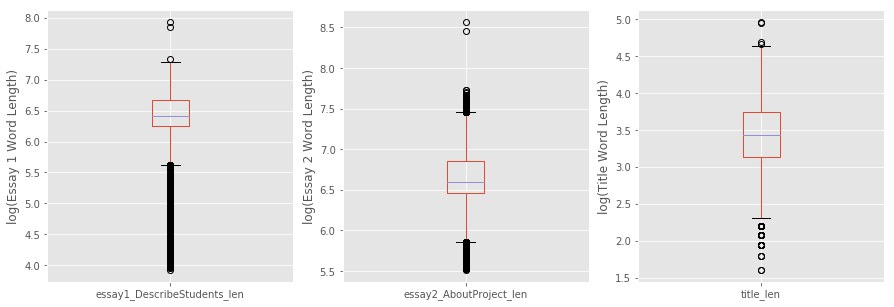

In [73]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
df.essay1_DescribeStudents_len.plot(kind='box')
plt.ylabel('log(Essay 1 Word Length)')
plt.subplot(1,3,2)
df.essay2_AboutProject_len.plot(kind='box')
plt.ylabel('log(Essay 2 Word Length)')
plt.subplot(1,3,3)
df.title_len.plot(kind='box')
plt.ylabel('log(Title Word Length)')
plt.show()

The boxplots above show the three new features added to this data set after the log transform has been applied

### Logistic Regression Model

Next, let's create a log regression model.  We will split the 'df' data set into a train and test set, setting aside 20% for test.

In [4]:
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'project_is_approved' in df:
    y = df['project_is_approved'].values # get the labels we want
    del df['project_is_approved'] # get rid of the class label
    X = df.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


Now we'll test the accuracy of the model.

In [5]:
# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None) # get object

# now we can use the cv_object that we setup before to iterate through the 
#    different training and testing sets. Each time we will reuse the logisitic regression 
#    object, but it gets trained on different data each time we use it.

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1
    
# Also note that every time you run the above code
#   it randomly creates a new training and testing set, 
#   so accuracy will be different each time

====Iteration 0  ====
accuracy 0.847507895098
confusion matrix
 [[    0  5553]
 [    0 30862]]
====Iteration 1  ====
accuracy 0.84888095565
confusion matrix
 [[    0  5503]
 [    0 30912]]
====Iteration 2  ====
accuracy 0.849842098037
confusion matrix
 [[    0  5468]
 [    0 30947]]


Although the model accuracy seems encouragingly high (especially for a first pass), a closer inspection of the confusion matrices above shows that this model is approving everything.  Since the overall approval rates in our data set are in the 85% range, the accuracy is not actually giving us any prediction lift.  We will need to do more to try to gain a better model.

Because of the high approval rates in the data set, we would like to test a balanced weight parameter in order to give the model a better training set to work with.  In order to do this, we will first create a shell that goes through each of the parameters in the model (keeping class_weight = 'balanced' as a fixed parameter).

In [6]:
#https://github.com/jakemdrew/EducationDataNC/blob/master/2017/Models/2017SegregatedHighSchoolCampuses.ipynb
#the next four blocks of code were sourced from Dr. Drew's analysis.  Link shown above.
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.10, random_state=0)

# we want to predict the X and y data as follows:
if 'project_is_approved' in df:
    y = df['project_is_approved'].values # get the labels we want
    del df['project_is_approved'] # get rid of the class label
    X = df.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
#Logisitic regression 10-fold cross-validation 
from sklearn.linear_model import LogisticRegression
regEstimator = LogisticRegression()

parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'class_weight': ['balanced'] #,'none']
              ,'random_state': [0]
              ,'solver': ['sag'] #['lbfgs']
              ,'max_iter':[100,500]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X, y)
#https://github.com/jakemdrew/EducationDataNC/blob/master/2017/Models/2017SegregatedHighSchoolCampuses.ipynb

Fitting 10 folds for each of 14 candidates, totalling 140 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   30.8s
[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:  4.0min finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'class_weight': ['balanced'], 'random_state': [0], 'solver': ['sag'], 'max_iter': [100, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [7]:
#https://github.com/jakemdrew/EducationDataNC/blob/master/2017/Models/2017SegregatedHighSchoolCampuses.ipynb

#Display the best estimator parameters
regGridSearch.best_estimator_

LogisticRegression(C=0.001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='sag', tol=0.0001, verbose=0, warm_start=False)

The results above show that the iterator chose C = 0.001 as the best value for the cost parameter.  Now, we will use these parameters to train and test the model.

In [8]:
#https://github.com/jakemdrew/EducationDataNC/blob/master/2017/Models/2017SegregatedHighSchoolCampuses.ipynb

#Use the best parameters for our Linear Regression object
classifierEst = regGridSearch.best_estimator_

from sklearn.model_selection import cross_validate

def EvaluateClassifierEstimator(classifierEstimator, X, y, cv):
   
    #Perform cross validation 
    scores = cross_validate(classifierEstimator, X, y, scoring=['accuracy','precision','recall']
                            , cv=cv, return_train_score=True)

    Accavg = scores['test_accuracy'].mean()
    Preavg = scores['test_precision'].mean()
    Recavg = scores['test_recall'].mean()

    print_str = "The average accuracy for all cv folds is: \t\t\t {Accavg:.5}"
    print_str2 = "The average precision for all cv folds is: \t\t\t {Preavg:.5}"
    print_str3 = "The average recall for all cv folds is: \t\t\t {Recavg:.5}"

    print(print_str.format(Accavg=Accavg))
    print(print_str2.format(Preavg=Preavg))
    print(print_str3.format(Recavg=Recavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['Accuracy'] = scores['test_accuracy']
    scoresResults['Precision'] = scores['test_precision']
    scoresResults['Recall'] = scores['test_recall']

    return scoresResults

def EvaluateClassifierEstimator2(classifierEstimator, X, y, cv):
    
    #Perform cross validation 
    from sklearn.model_selection import cross_val_predict
    predictions = cross_val_predict(classifierEstimator, X, y, cv=cv)
    
    #model evaluation 
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    
    #pass true test set values and predictions to classification_report
    classReport = classification_report(y,predictions)
    confMat = confusion_matrix(y,predictions)
    acc = accuracy_score(y,predictions)
    
    print(classReport)
    print(confMat)
    print(acc)

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(classifierEst, X, y, cv)

The average accuracy for all cv folds is: 			 0.58375
The average precision for all cv folds is: 			 0.892
The average recall for all cv folds is: 			 0.57981
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.582986,0.890920,0.579965
1,0.586610,0.897156,0.579533
2,0.577988,0.886468,0.575302
3,0.592761,0.896752,0.588680
4,0.577548,0.890933,0.572915
5,0.586995,0.889141,0.584972
6,0.579910,0.888567,0.576145
7,0.582326,0.893549,0.577775
8,0.591663,0.894133,0.589114
9,0.578702,0.892394,0.573698


The output above shows the results of a ten fold cross-validation on the model with a balanced data set.  We see the accuracy is much lower than the initial model.  However, we suspect that this is due to the fact that the initial model was approving all projects.  

Next, let's take a look at the confusion matrix for the balanced model.

In [9]:
EvaluateClassifierEstimator2(classifierEst, X, y, 10)

             precision    recall  f1-score   support

          0       0.21      0.61      0.31     27734
          1       0.89      0.58      0.70    154339

avg / total       0.79      0.58      0.64    182073

[[16948 10786]
 [64904 89435]]
0.584287620899


The results from the confusion matrix above confirms that the balanced model, although much less accurate, is now making better predictions between project approval and denial.

Now, we will run this balanced model on a train and test set with 20% held out for testing.  The goal is to achieve similar accuracies and confusion matrices as above.

In [10]:
#https://github.com/jakemdrew/EducationDataNC/blob/master/2017/Models/2017SegregatedHighSchoolCampuses.ipynb


# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(C=0.001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='sag', tol=0.0001, verbose=0, warm_start=False) # get object

# now we can use the cv_object that we setup before to iterate through the 
#    different training and testing sets. Each time we will reuse the logisitic regression 
#    object, but it gets trained on different data each time we use it.

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1
    
# Also note that every time you run the above code
#   it randomly creates a new training and testing set, 
#   so accuracy will be different each time

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)
====Iteration 0  ====
accuracy 0.590388576136
confusion matrix
 [[ 3419  2174]
 [12742 18080]]
====Iteration 1  ====
accuracy 0.583688040643
confusion matrix
 [[ 3398  2096]
 [13064 17857]]
====Iteration 2  ====
accuracy 0.584017575175
confusion matrix
 [[ 3315  2153]
 [12995 17952]]


The results above show accuracies that range between 58.2 and 58.6%.  We can also see from the confusion matrices that the balanced model is no longer approving every project in the data set.

The next step will be to run the model through a standard scaler operation.  We do this in order to be able to interpret all model weights on the same domain.

In [11]:
#https://github.com/jakemdrew/EducationDataNC/blob/master/2017/Models/2017SegregatedHighSchoolCampuses.ipynb


from sklearn.preprocessing import StandardScaler

# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
lr_clf = LogisticRegression(C=0.001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)  
lr_clf.fit(X_train_scaled,y_train)  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf )

# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,df.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

accuracy: 0.58679115749
[[ 3324  2144]
 [12903 18044]]
Total_Cost has weight of -0.294790835374
essay1_DescribeStudents_len has weight of -0.0750637525928
project_grade_category_Grades PreK-2 has weight of -0.0367004931467
teacher_prefix_Teacher has weight of -0.0306636538801
title_len has weight of 0.0306570781545
True_Quantity has weight of 0.0370176538285
teacher_number_of_previously_posted_projects has weight of 0.207473578188
essay2_AboutProject_len has weight of 0.267511477044
Average_item_cost has weight of 0.373636576823


Now that the weights have been scaled, let's view them graphically.  This will be used later when we interpret the model weights.

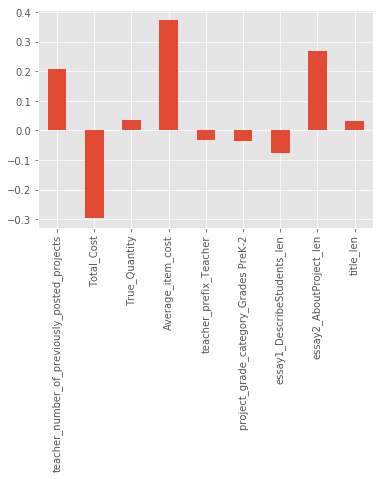

In [12]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

weights = pd.Series(lr_clf.coef_[0],index=df.columns)
weights.plot(kind='bar')
plt.show()

The bar plot above shows the relative feature weights of the balanced model.

### Support Vector Machines

Although we have improved the initial model by balancing, let's take a look at using support vector machines to see if this can add any additional lift.

In [84]:
# okay, so run through the cross validation loop and set the training and testing variable for one single iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test)

In [94]:
# lets investigate SVMs on the data and play with the parameters and kernels
from sklearn.svm import SVC
import time
start_time = time.time()

# train the model just as before
svm_clf = SVC(C=0.001, kernel='linear') #, degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

print("Training time: %s seconds" % (time.time() - start_time))   #https://stackoverflow.com/questions/1557571/how-do-i-get-time-of-a-python-programs-execution
y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

Training time: 119.80442023277283 seconds
accuracy: 0.8461897569682822
[[    0  5601]
 [    0 30814]]


The confusion matrix above shows the prediction results using SVM.  Unfortunately, the SVM appears to be doing the same as the initial log regression model and approving everything.

Let's take a look at the support vectors.

In [86]:
# look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(44393, 9)
(44393,)
[22133 22260]


Next, we will visualize the support vectors using density plots and look at the distributions both after and before using the support vectors.

In [87]:
# Now let's do some different analysis with the SVM and look at the instances that were chosen as support vectors

# now lets look at the support for the vectors and see if we they are indicative of anything
# grabe the rows that were selected as support vectors (these are usually instances that are hard to classify)

# make a dataframe of the training data
df_tested_on = df.iloc[train_indices] # saved from above, the indices chosen for training
# now get the support vectors from the trained model
df_support = df_tested_on.iloc[svm_clf.support_,:]

df_support['project_is_approved'] = y[svm_clf.support_] # add back in the 'Survived' Column to the pandas dataframe
df['project_is_approved'] = y # also add it back in for the original data
df_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44393 entries, 113028 to 168016
Data columns (total 10 columns):
teacher_number_of_previously_posted_projects    44393 non-null float64
Total_Cost                                      44393 non-null float64
True_Quantity                                   44393 non-null float64
Average_item_cost                               44393 non-null float64
teacher_prefix_Teacher                          44393 non-null uint8
project_grade_category_Grades PreK-2            44393 non-null uint8
essay1_DescribeStudents_len                     44393 non-null float64
essay2_AboutProject_len                         44393 non-null float64
title_len                                       44393 non-null float64
project_is_approved                             44393 non-null int64
dtypes: float64(7), int64(1), uint8(2)
memory usage: 3.1 MB


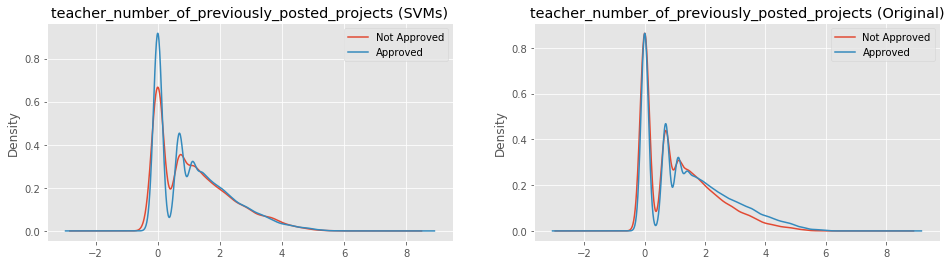

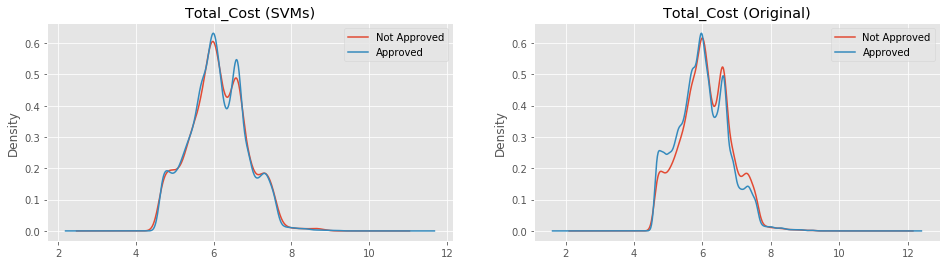

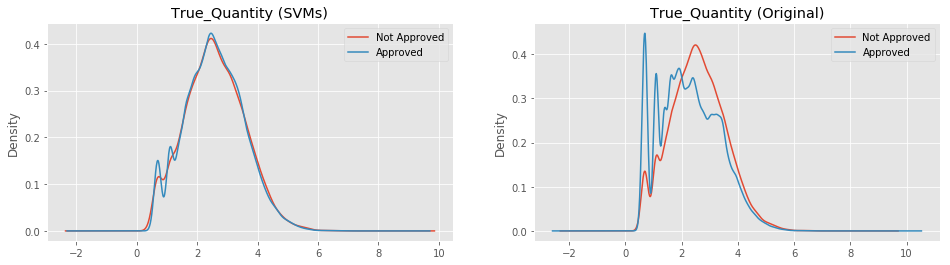

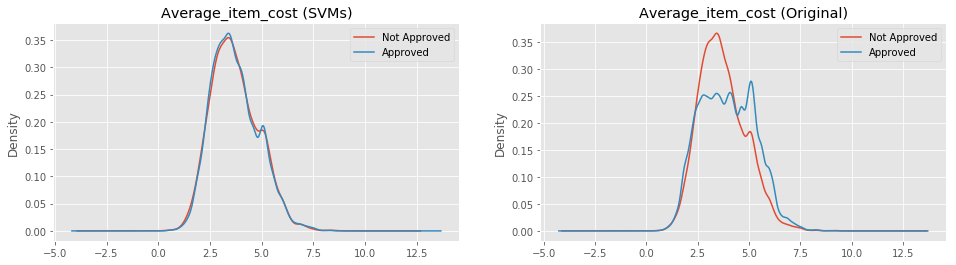

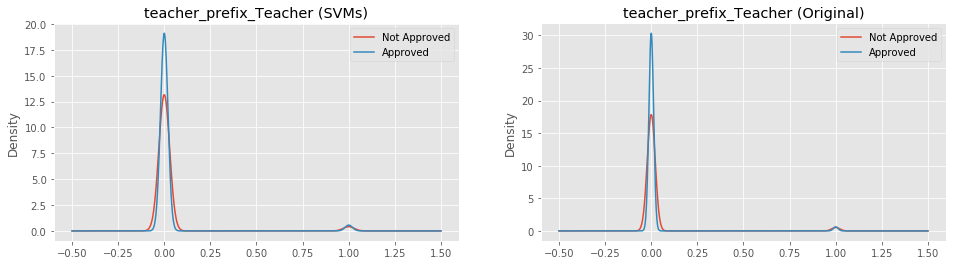

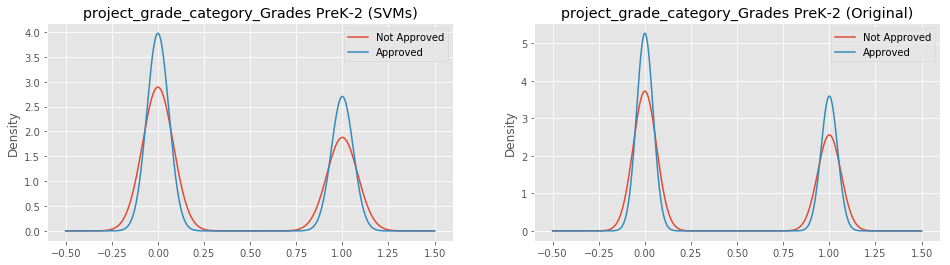

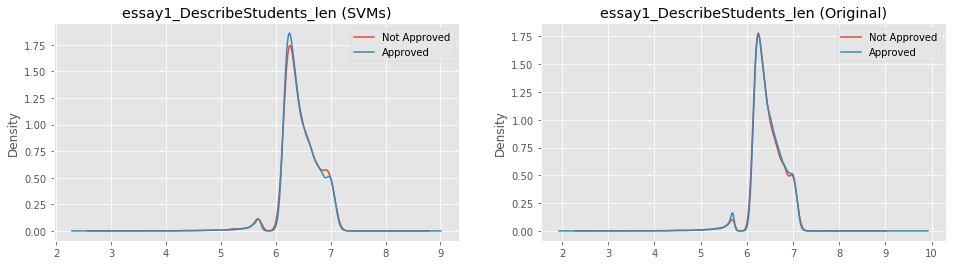

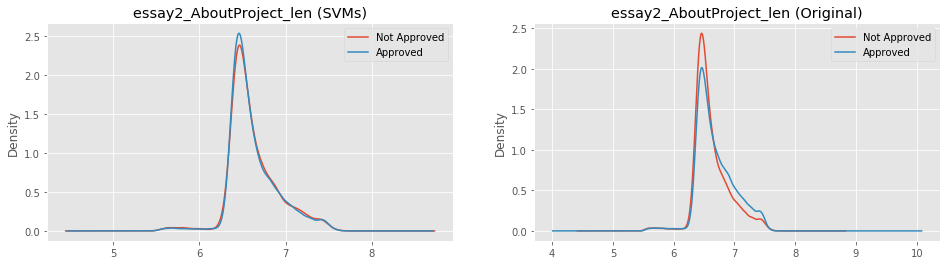

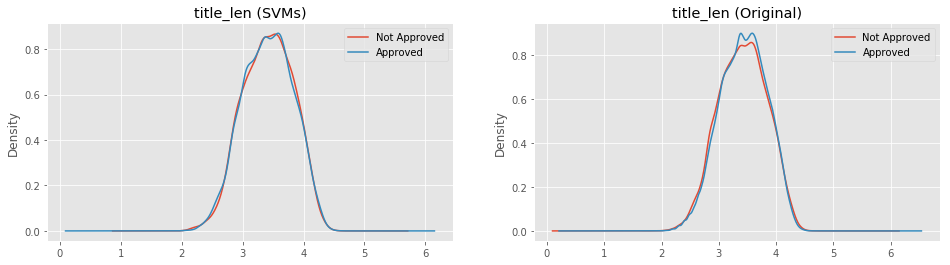

In [59]:
# now lets see the statistics of these attributes
from pandas.tools.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['project_is_approved'])
df_grouped = df.groupby(['project_is_approved'])

# plot KDE of Different variables
vars_to_plot = ['teacher_number_of_previously_posted_projects','Total_Cost','True_Quantity','Average_item_cost'
                ,'teacher_prefix_Teacher','project_grade_category_Grades PreK-2'
                ,'essay1_DescribeStudents_len','essay2_AboutProject_len','title_len']

for v in vars_to_plot:
    plt.figure(figsize=(16,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['Not Approved','Approved'])
    plt.title(v+' (SVMs)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['Not Approved','Approved'])
    plt.title(v+' (Original)')

The graphs above display the density plots for the continuous features in the model, both after and before using the support vectors.  We will interpret these support vectors in detail at the end of this write-up.

## Create Models - Conclusion

The initial first-pass logistic regression model had high accuracy (85%), but a closer inspection of the resulting test confusion matrices showed that this was only because the initial model was approving all projects.  

The second logistic regression model had much lower accuracy (58%).  However, by using a balanced weight method to train the model we were able to achieve a model that does a better job at predicting projects that will not be approved.

The SVM model had the same issue as the inital logistic model where it had high accuracy (85%) but approves all projects.

In summary, it appears that the best candidate model to choose from these three is the logistic regression model that balances the training set weights between project is approved or not approved.  We will need to consider adding new features to this model in order to gain higher lift using the balanced model.

Average_item_cost has weight of -0.0011026541591132588
True_Quantity has weight of -0.0009860030076009885
essay2_AboutProject_len has weight of -8.569559540427818e-06
teacher_prefix_Teacher has weight of 1.3988810110276972e-14
teacher_number_of_previously_posted_projects has weight of 4.866622380195196e-06
title_len has weight of 8.804526013733716e-06
project_grade_category_Grades PreK-2 has weight of 1.0859643997468416e-05
essay1_DescribeStudents_len has weight of 1.484870370226099e-05
Total_Cost has weight of 0.0006346942493729024


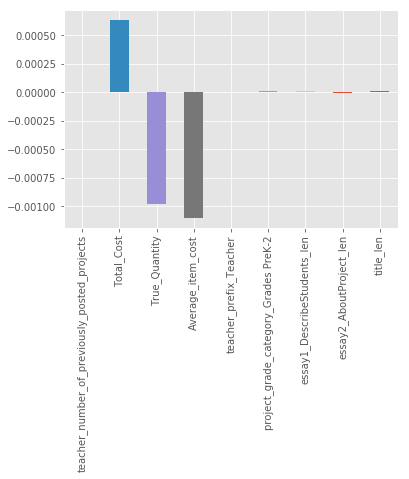

In [93]:
zip_vars = zip(svm_clf.coef_.T,df.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out
    
# now let's make a pandas Series with the names and values, and plot them


from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

weights2 = pd.Series(svm_clf.coef_[0],index=df.columns[:9])
weights2.plot(kind='bar')
plt.show()

# Model Advantages

Both the logistic regression and linear support vector machine models produced practically identical models that approved all projects in the training set. However, it is important to note that the logistic regression model was significantly faster to train that the SVM model. When testing various model parameters, 140 logistic regression models were able to be trained in 1.8 minutes. However, just a single linear SVM model training took 119.8 seconds, or 2 minutes. This makes logistic regresion approximately 140 times faster than SVM for this data set. This is very significant when it comes to implementing the algorithm, specifically if the data set was to get larger.

# Interpret Feature Importance

In order to understand what features contribute the most to the model, the coefficients are examined. Printed above, the coefficients for the logistic regression are repeated here for reference: 

In [13]:
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

Total_Cost has weight of -0.294790835374
essay1_DescribeStudents_len has weight of -0.0750637525928
project_grade_category_Grades PreK-2 has weight of -0.0367004931467
teacher_prefix_Teacher has weight of -0.0306636538801
title_len has weight of 0.0306570781545
True_Quantity has weight of 0.0370176538285
teacher_number_of_previously_posted_projects has weight of 0.207473578188
essay2_AboutProject_len has weight of 0.267511477044
Average_item_cost has weight of 0.373636576823


Because these are coefficients from a model using scaled features, we can directly compare them for their significance. This is a main advantage of using scaled variables. This approach does further complicate an already complicated marginal effect interpretation for logistic regression. As such, the primary focus here is on which features are most important, not what these features do to drive the values of the outcome.

To do this, we can look at a ranked plot of the absolute value of the weights with their feature names.

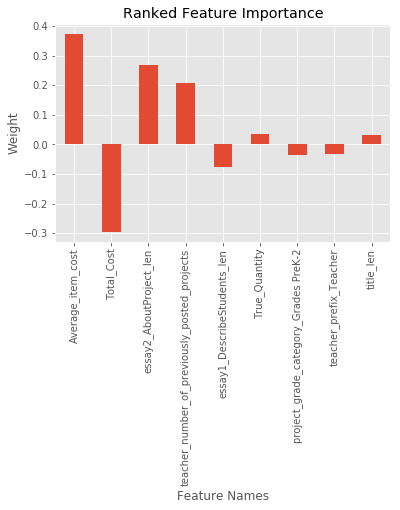

In [17]:
# now let's make a pandas Series with the names and values, and plot them
# reference for code: https://github.com/jakemdrew/EducationDataNC/blob/master/2017/Models/2017SegregatedHighSchoolCampuses.ipynb

from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

weights = lr_clf.coef_.ravel()
feature_names = df.columns.values

logreg_features = pd.DataFrame({'feature_names': feature_names, 'weights': weights, 'absolute_weights':np.abs(weights)})
logreg_features.sort_values(by='absolute_weights', inplace=True, ascending = False)

weights = pd.Series(logreg_features['weights'].values, index=logreg_features['feature_names'])
px = weights.plot(kind='bar')
px.set_xlabel("Feature Names")
px.set_ylabel("Weight")
px.set_title("Ranked Feature Importance")
plt.show()

From the above plot, there are a number of interesting observations.
- The Average_item_cost feature has the highest weight, and thereby has the greatest influence on the outcome of the regression. The second most significant feature is Total_cost, with an opposite direction effect. Because these two attributes are derived from similar data, there may be some correlation. That said, these are important factors that can characterize a project in DonorsChoose: teachers requesting a large number of small cost items such as books for a classroom, compared with teachers requesting one or two high cost items such as iPads could end up having the same overall cost. 
- The third most important feature in the logistic regression is the length of the response to Essay 2. This is the question in which teachers explain what the project is that they are requesting. Perhaps the longer essays are more well thought out, and have a better chance of being approved for posting. 
- The fourth most important feature is how many projects a teacher has previously posted. This suggests that the more practice a teacher has at filling out the application, the more likely they are to be approved. 
- The first four features listed above have an absolute value greater than 0.2. After these first four features, there is a sizeable drop off in the amount of the weight, to below 0.1 (absolute value). While possibly useful in the model, these have a much smaller effect on the outcome than the first four. 

# Interpret Support Vectors
